In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision.all import *
from PIL import Image, ImageDraw
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
from hrnet import hrnet18, hrnet32
from tqdm import tqdm
import shutil

In [3]:
# generate annotation keypoints
anno_path = "/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/annotations/"

# mapping dict
dtypes = {"Image ID": object}
df_82 = pd.read_csv(anno_path + '816_288_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
df_93 = pd.read_csv(anno_path + '960_384_Patient_EID_master_list_v2.csv', sep = '\t', dtype = dtypes)
dict_82 = df_82[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()
dict_93 = df_93[['File', "Image ID"]].set_index("File")['Image ID'].to_dict()

# load coco annotation result
anno_82 = json.load(open(os.path.join(anno_path, "tv_82_23kps.json")))
anno_93 = json.load(open(os.path.join(anno_path, "tv_93_23kps.json")))

# convert coco result to keypoints
anno_23kps = {}

for img in anno_82['images']:
    img_id = img['id']
    file_name = img['file_name']
    image_id = dict_82[file_name]
    for i in anno_82['annotations']:
        if i['image_id'] == img_id:
            kps = np.array(i['keypoints']).reshape(-1, 3)[:, :2]
            # according to central crop, adjust x,y
            kps[:, 0] = kps[:, 0] - 16
            kps[:, 1] = kps[:, 1] - 230
            kps = kps.tolist()
    anno_23kps[image_id  + '_82'] = kps

for img in anno_93['images']:
    img_id = img['id']
    file_name = img['file_name']
    image_id = dict_93[file_name]
    for i in anno_93['annotations']:
        if i['image_id'] == img_id:
            kps = np.array(i['keypoints']).reshape(-1, 3)[:, :2]
            # according to central crop, adjust x,y
            kps[:, 0] = kps[:, 0] - 64
            kps[:, 1] = kps[:, 1] - 302
            kps = kps.tolist()
    anno_23kps[image_id  + '_93'] = kps

In [18]:
def get_pos(path):
    img_id = str(path).split("/")[-1].split(".")[0]
    coord = anno_23kps[img_id]
    return tensor(coord)

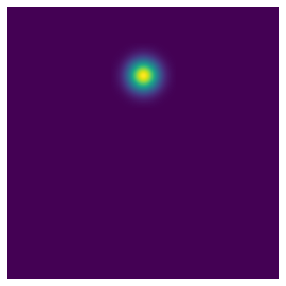

In [7]:
# A gaussian kernel cache, so we don't have to regenerate them every time.
# This is only a small optimization, generating the kernels is pretty fast.
_gaussians = {}

def generate_gaussian(t, x, y, sigma=10):
    """
    Generates a 2D Gaussian point at location x,y in tensor t.

    x should be in range (-1, 1) to match the output of fastai's PointScaler.

    sigma is the standard deviation of the generated 2D Gaussian.
    """
    h,w = t.shape

    # Heatmap pixel per output pixel
    mu_x = int(0.5 * (x + 1.) * w)
    mu_y = int(0.5 * (y + 1.) * h)

    tmp_size = sigma * 3

    # Top-left
    x1,y1 = int(mu_x - tmp_size), int(mu_y - tmp_size)

    # Bottom right
    x2, y2 = int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)
    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        return t

    size = 2 * tmp_size + 1
    tx = np.arange(0, size, 1, np.float32)
    ty = tx[:, np.newaxis]
    x0 = y0 = size // 2

    # The gaussian is not normalized, we want the center value to equal 1
    g = _gaussians[sigma] if sigma in _gaussians \
                else tensor(np.exp(- ((tx - x0) ** 2 + (ty - y0) ** 2) / (2 * sigma ** 2)))
    _gaussians[sigma] = g

    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1

    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)

    t[img_y_min:img_y_max, img_x_min:img_x_max] = \
      g[g_y_min:g_y_max, g_x_min:g_x_max]

    return t

# Example:
show_image(generate_gaussian(torch.zeros(256, 256), 0, -0.5))

In [8]:
import itertools

# FastAIs `TensorPoint` class comes with a default `PointScaler` transform
# that scales the points to (-1, 1). This little function does the same
# given a point / tensor of points and original size.
def _scale(p, s): return 2 * (p / s) - 1

def heatmap2argmax(heatmap, scale=False):
    N, C, H, W = heatmap.shape
    index = heatmap.view(N,C,1,-1).argmax(dim=-1)
    pts = torch.cat([index%W, index//W], dim=2)

    if scale:
        scale = tensor([W,H], device=heatmap.device)
        pts = _scale(pts, scale)

    return pts

class Heatmap(TensorImageBase):
    "Heatmap tensor, we can use the type to modify how we display things"
    pass

class HeatmapPoint(TensorPoint):
    """
    A class that mimics TensorPoint, but wraps it so
    we'll be able to override `show` methods with
    a different type.
    """
    pass

class HeatmapTransform(Transform):
    """
    A batch transform that turns TensorPoint instances into Heatmap instances,
    and Heatmap instances into HeatmapPoint instances.

    Used as the last transform after all other transformations.
    """
    # We want the heat map transformation to happen last, so give it a high order value
    order=999

    def __init__(self, heatmap_size, sigma=10, **kwargs):
        """
        heatmap_size: Size of the heatmap to be created
        sigma: Standard deviation of the Gaussian kernel
        """
        super().__init__(**kwargs)
        self.sigma = sigma
        self.size = heatmap_size

    def encodes(self, x:TensorPoint):
        # The shape of x is (batch x n_points x 2)
        num_imgs = x.shape[0]
        num_points = x.shape[1]

        maps = Heatmap(torch.zeros(num_imgs, num_points, *self.size, device=x.device))
        for b,c in itertools.product(range(num_imgs), range(num_points)):
            # Note that our point is already scaled to (-1, 1) by PointScaler
            point = x[b][c]
            generate_gaussian(maps[b][c], point[0], point[1], sigma=self.sigma)

        return maps

    def decodes(self, x:Heatmap):
        """
        Decodes a heat map back into a set of points by finding
        the coordinates of their argmax.

        This returns a HeatmapPoint class rather than a TensorPoint
        class, so we can modify how we display the output.
        """
        # Flatten the points along the final axis,
        # and find the argmax per channel
        xy = heatmap2argmax(x, scale=True)
        return HeatmapPoint(xy, source_heatmap=x)

In [9]:
@typedispatch
def show_batch(x:TensorImage, y:HeatmapPoint, samples, ctxs=None,
               max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    """
    Custom show_batch for a TensorImage / Heatmap pair, that shows
    the predicted points as well as the heat maps. Note that this method ignores
    nrows / ncols entirely.
    """
    # x is a list of TensorImages
    # y is a list of Heatmaps
    # samples is a list of (TensorImage, HeatmapPoint) tuples

    # Number of items to display
    n = min(len(samples), max_n)

    # Could also get this from the number of points
    n_heatmaps = y[0].shape[0]

    cols = 1 + n_heatmaps

    if ctxs is None:
        ctxs = get_grid(cols * n, nrows=n, ncols=cols, figsize=figsize)

    # Show the image overlaid with the points
    for ctx,sample,_ in zip(ctxs[0::cols], samples, range(n)):
        sample[0].show(ctx=ctx, **kwargs)
        sample[1].show(ctx=ctx, **kwargs)

    # Show the individual heatmaps
    heatmaps = y.source_heatmap
    for i in range(n_heatmaps):
        # I'd add the `y` to the `zip`, but it's upcasted
        # to a tensor when iterated (but not when indexed)
        ctxs[i+1::cols] = [heatmaps[j][i].show(ctx=ctx, cmap='viridis', vmin=0, vmax=1, **kwargs)
                           for ctx,j in zip(ctxs[i+1::cols], range(n))]

    return ctxs

In [10]:
def nmae_argmax(preds, targs):
    # Note that our function is passed two heat maps, which we'll have to
    # decode to get our points. Adding one and dividing by 2 puts us
    # in the range 0...1 so we don't have to rescale for our percentual change.
    preds = 0.5 * (TensorBase(heatmap2argmax(preds, scale=True)) + 1)
    targs = 0.5 * (TensorBase(heatmap2argmax(targs, scale=True)) + 1)

    return ((preds-targs).abs()).mean()

def gaussian_heatmap_loss(pred, targs):
    targs = TensorBase(targs)
    pred = TensorBase(pred)
    return F.mse_loss(pred, targs)

In [11]:
@typedispatch
def show_results(x:TensorImage, y:HeatmapPoint, samples, outs, ctxs=None, max_n=10, nrows=None,
                 ncols=None, figsize=None, **kwargs):
    # x,y,samples are all reference (target) data, same as show_batch:
    # x is a list of TensorImages
    # y is a list of Heatmaps
    # samples is a list of (TensorImage, HeatmapPoint) tuples
    # outs contains a list of our predicted HeatmapPoint instances.

    # Number of items to display
    n = min(len(samples), max_n)

    # Could also get this from the number of points
    n_heatmaps = y[0].shape[0]

    # We're going to display the input image with target points,
    # the input image again with the predicted points, and
    # the predicted heat maps.
    cols = 2 + n_heatmaps

    if ctxs is None:
        ctxs = get_grid(cols * n, nrows=n, ncols=cols, figsize=figsize,
                       title='Target/Prediction/Heatmaps')

    # Show the target image overlaid with the points, and
    # the target image overlaid with the predicted points
    for tctx,pctx,sample,out,_ in zip(ctxs[0::cols], ctxs[1::cols], samples, outs, range(n)):
        sample[0].show(ctx=tctx, **kwargs)
        sample[1].show(ctx=tctx, **kwargs)
        sample[0].show(ctx=pctx, **kwargs)
        out[0].show(ctx=pctx, **kwargs)

    # Show the predicted heat maps
    # Note that each value in outs will contain all our source heatmaps,
    # because of the way fastai copies the metadata.
    heatmaps = outs[0][0].source_heatmap
    for i in range(n_heatmaps):
        # I'd add the heatmaps to the `zip`, but it's upcasted
        # to a tensor when iterated (but not when indexed)
        ctxs[i+2::cols] = [heatmaps[j][i].show(ctx=ctx, cmap='viridis', **kwargs)
                           for ctx,j in zip(ctxs[i+2::cols], range(n))]

    return ctxs

In [12]:
def coord2heatmap(x, y, w, h, heatmap):
    """
    Inserts a coordinate (x,y) from a picture with
    original size (w x h) into a heatmap, by randomly assigning
    it to one of its nearest neighbor coordinates, with a probability
    proportional to the coordinate error.

    Arguments:
    x: x coordinate
    y: y coordinate
    w: original width of picture with x coordinate
    h: original height of picture with y coordinate
    """
    # Get scale
    oh,ow = heatmap.shape
    sx = ow / w
    sy = oh / h

    # Unrounded target points
    px = x * sx
    py = y * sy

    # Truncated coordinates
    nx,ny = int(px), int(py)

    # Coordinate error
    ex,ey = px - nx, py - ny

    xyr = torch.rand(2, device=heatmap.device)
    xx = (ex >= xyr[0]).long()
    yy = (ey >= xyr[1]).long()
    heatmap[min(ny + yy, heatmap.shape[0] - 1),
            min(nx+xx, heatmap.shape[1] - 1)] = 1

    return heatmap

In [13]:
def heatmap2coord(heatmap, topk=9):
    N, C, H, W = heatmap.shape
    score, index = heatmap.view(N,C,1,-1).topk(topk, dim=-1)
    coord = torch.cat([index%W, index//W], dim=2)
    return (coord*F.softmax(score, dim=-1)).sum(-1)

def topk_heatmap2coord(heatmap, topk=9, scale=False):
    coord = heatmap2coord(heatmap, topk)
    if scale:
        _, _, H, W = heatmap.shape
        scale = tensor([W,H], device=heatmap.device)
        coord = _scale(coord, scale)

    return coord

class RandomBinaryHeatmapTransform(Transform):
    order=999

    def __init__(self, heatmap_size, topk=9, **kwargs):
        super().__init__(**kwargs)
        self.size = tensor(heatmap_size)
        self.topk=topk

    def encodes(self, x:TensorPoint):
        # The shape of x is (batch x n_points x 2)
        num_imgs = x.shape[0]
        num_points = x.shape[1]

        maps = Heatmap(torch.zeros(num_imgs, num_points, *self.size, dtype=torch.long,
                                   device=x.device))
        for b,c in itertools.product(range(num_imgs), range(num_points)):
            heatmap = maps[b][c]

            # Note that our point is already scaled to (-1, 1) by PointScaler.
            # We pretend here it's in range 0...2
            point = x[b][c] + 1.
            coord2heatmap(point[0], point[1], 2., 2., heatmap)

        return maps

    def decodes(self, x:Heatmap):
        """
        Decodes a batch of binary heatmaps back into a set of
        TensorPoints.
        """
        if x.dtype == torch.long:
            # If the target heatmap is an annotation heatmap, our
            # decoding procedure is different - we need to directly
            # retrieve the argmax.
            return HeatmapPoint(heatmap2argmax(x, scale=True),
                               source_heatmap=x)

        return HeatmapPoint(topk_heatmap2coord(x, topk=self.topk, scale=True),
                           source_heatmap=x)

In [15]:
backbone = hrnet32(pretrained=True).eval()
example = torch.rand(23, 3, 256, 256)
backbone(example).shape

torch.Size([23, 480, 64, 64])

In [16]:
class BinaryHeadBlock(nn.Module):
    def __init__(self, in_channels, proj_channels, out_channels, **kwargs):
        super(BinaryHeadBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, proj_channels, 1, bias=False),
            nn.BatchNorm2d(proj_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(proj_channels, out_channels, 1, bias=False),
        )

    def forward(self, input):
        return self.layers(input)

head = BinaryHeadBlock(480, 480, 23)
nn.Sequential(backbone, head).eval()(example).shape

torch.Size([23, 23, 64, 64])

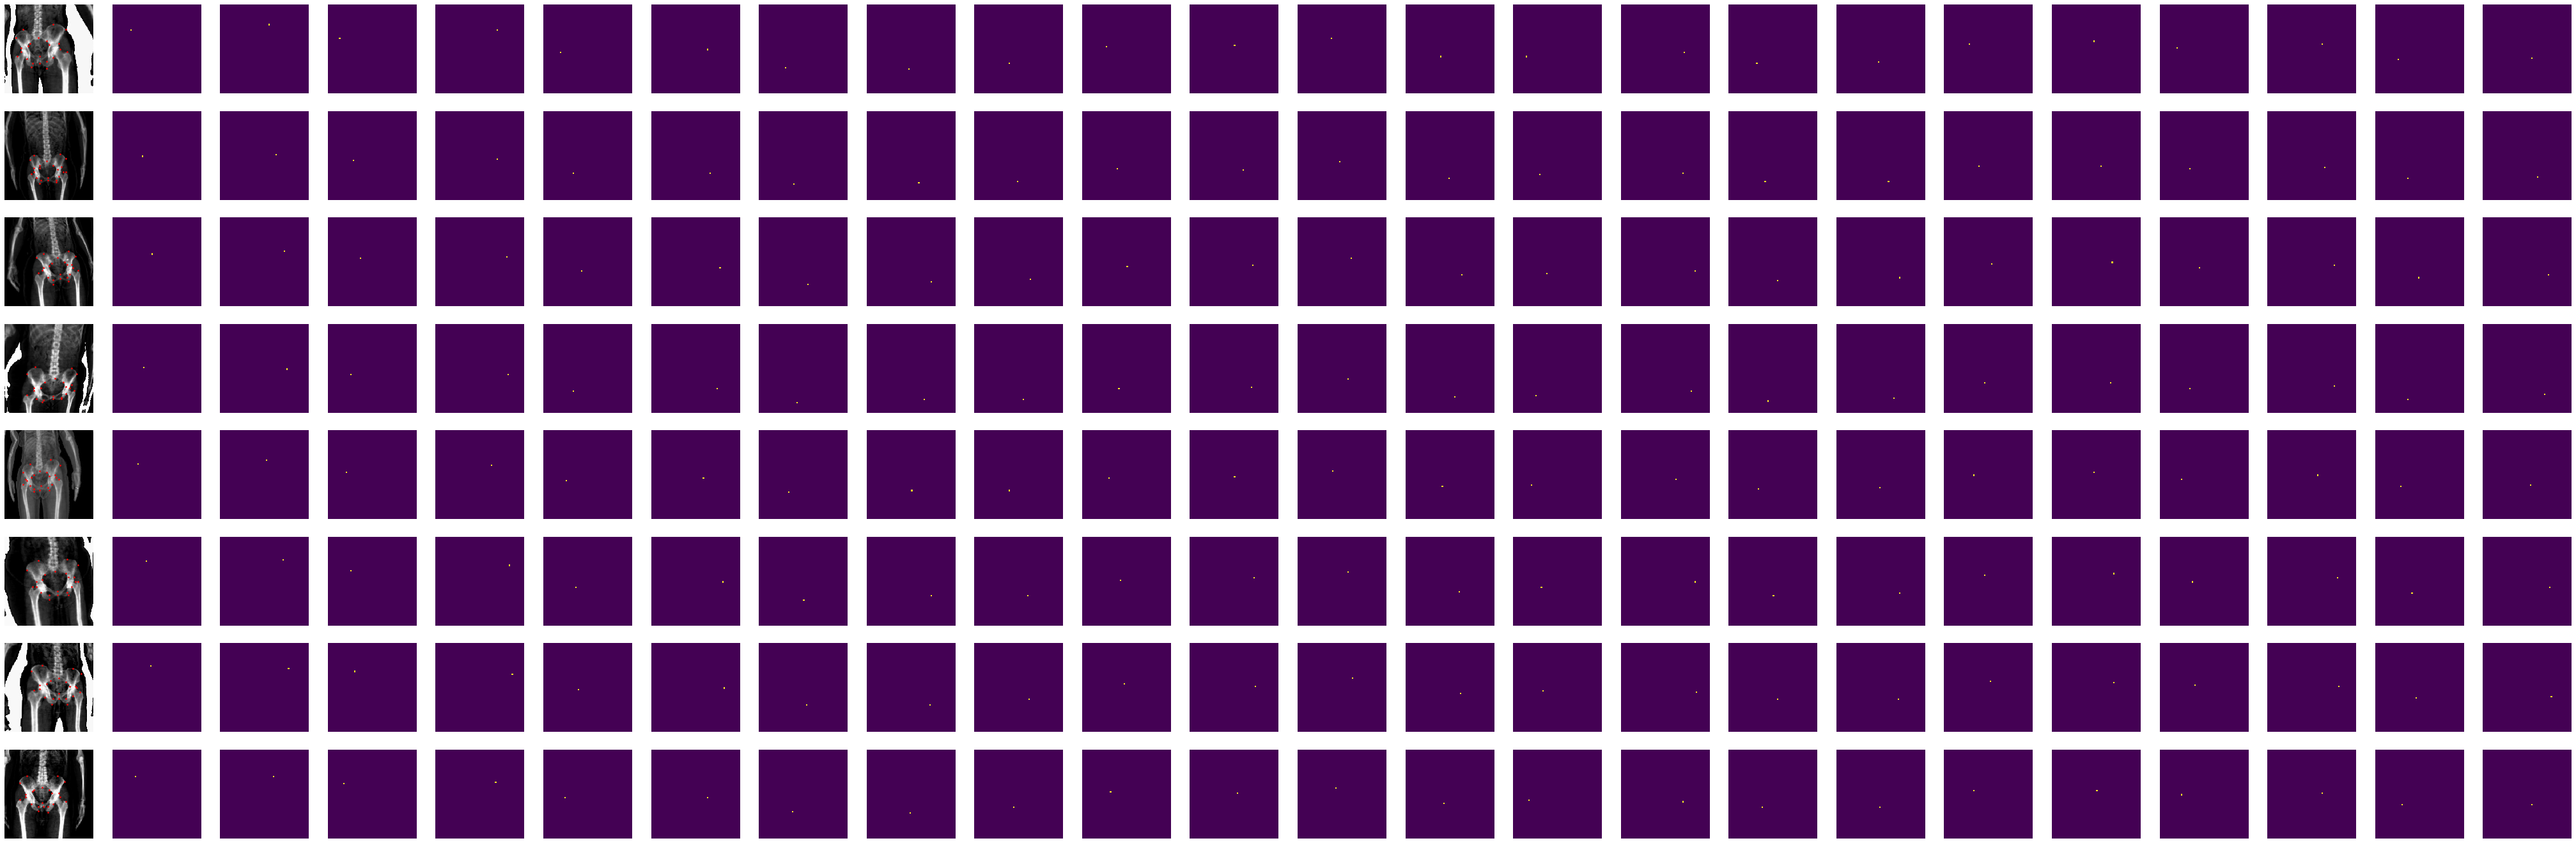

In [19]:
SIZE=(256, 256)
HM_SIZE=(64, 64)
root_path = "/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/"
img_files = os.path.join(root_path, "tv_images_cp")

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_pos,
    batch_tfms=[*aug_transforms(size=SIZE, do_flip=False), 
                Normalize.from_stats(*imagenet_stats),
                RandomBinaryHeatmapTransform(heatmap_size=HM_SIZE)],
    splitter=RandomSplitter()
)

dls = dblock.dataloaders(img_files, bs=16)
dls.show_batch(max_n=8)

In [20]:
dls.train.items

[Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/11702_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01751_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/04255_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/00847_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/10254_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/15855_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/07101_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/13072_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/05561_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/10673_82.jpg'),
 Path('/work2/09059/

In [21]:
dls.valid.items

[Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/11276_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/06157_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/08221_93.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/01460_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/13299_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/00157_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/15233_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/12106_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/11703_82.jpg'),
 Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/tv_images_cp/10377_82.jpg'),
 Path('/work2/09059/

In [22]:
def binary_heatmap_loss(preds, targs, pos_weight=None, topk=9):
    preds = TensorBase(preds)
    targs = TensorBase(targs).float()

    if pos_weight is not None:
        _,p,h,w=preds.shape
        pos_weight=torch.tensor(pos_weight, device=preds.device).expand(p, h, w)

    return F.binary_cross_entropy_with_logits(preds, targs, pos_weight=pos_weight)    

In [23]:
backbone = hrnet32(pretrained = True)
head = BinaryHeadBlock(480, 480, 23)
model = nn.Sequential(backbone, head)

def nmae_topk(preds, targs, topk=9):
    # Note that our function is passed two heat maps, which we'll have to
    # decode to get our points. Adding one and dividing by 2 puts us
    # in the range 0...1 so we don't have to rescale for our percentual change.
    preds = 0.5 * (TensorBase(topk_heatmap2coord(preds, topk=topk, scale=True)) + 1)
    targs = 0.5 * (TensorBase(heatmap2argmax(targs, scale=True)) + 1)

    return ((preds-targs).abs()).mean()

learn = Learner(dls, model, loss_func=partial(binary_heatmap_loss, pos_weight=100), metrics=[nmae_topk])

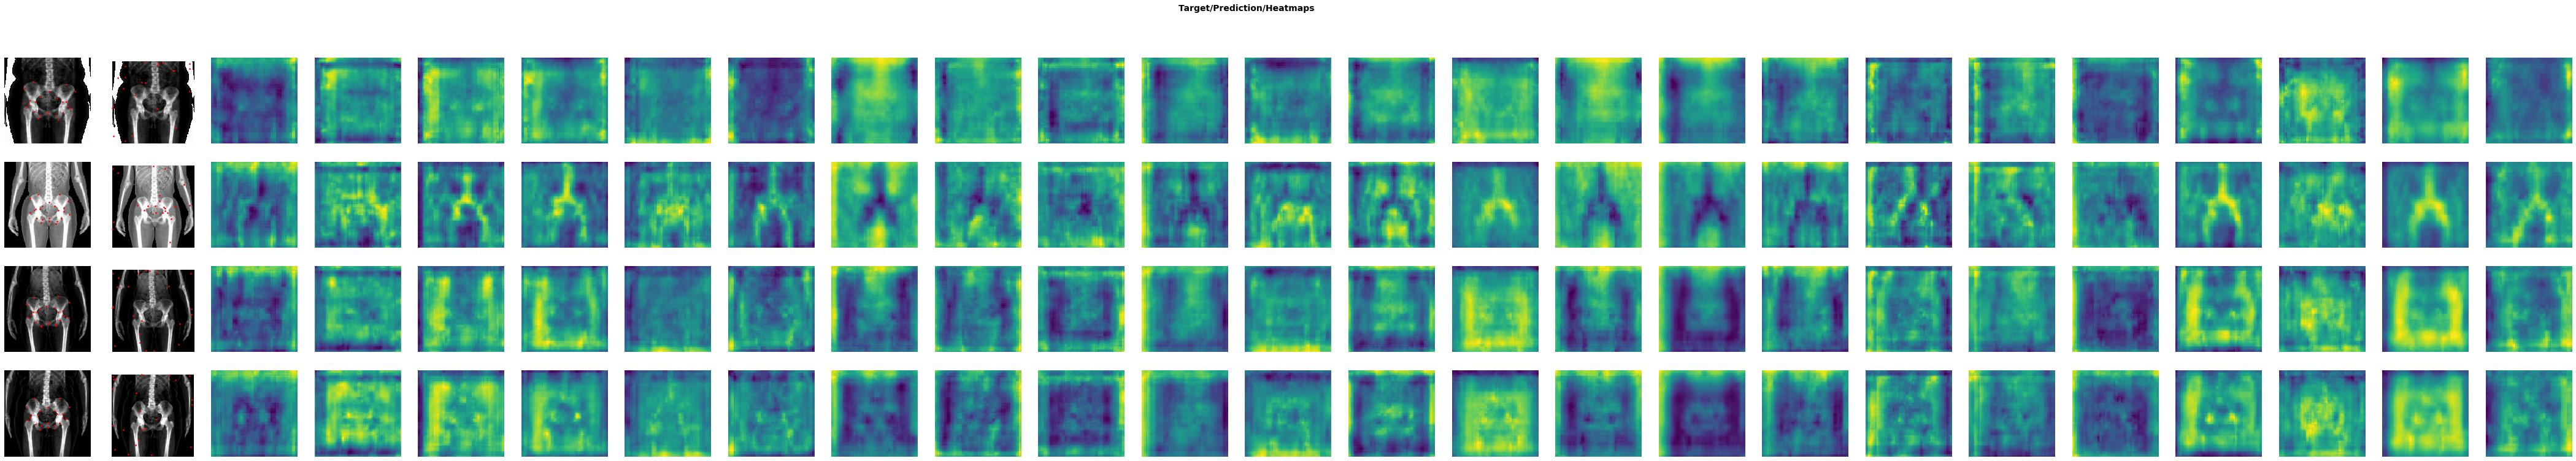

In [24]:
learn.show_results(max_n=4)

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.002511886414140463)

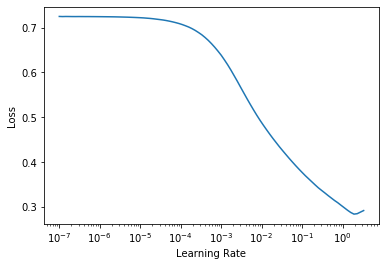

In [25]:
learn.lr_find()

In [26]:
learn.fine_tune(100, 2.5e-3,
                cbs=[EarlyStoppingCallback(monitor='nmae_topk', patience=50, comp = np.less),
                     SaveModelCallback(monitor='nmae_topk', comp = np.less)])

Better model found at epoch 0 with nmae_topk value: 0.12605425715446472.


Better model found at epoch 0 with nmae_topk value: 0.11944776028394699.
Better model found at epoch 1 with nmae_topk value: 0.08226218819618225.
Better model found at epoch 2 with nmae_topk value: 0.053161825984716415.
Better model found at epoch 3 with nmae_topk value: 0.024502934888005257.
Better model found at epoch 4 with nmae_topk value: 0.014400471933186054.
Better model found at epoch 5 with nmae_topk value: 0.013180098496377468.
Better model found at epoch 6 with nmae_topk value: 0.009623566642403603.
Better model found at epoch 7 with nmae_topk value: 0.008238408714532852.
Better model found at epoch 8 with nmae_topk value: 0.007806393783539534.
Better model found at epoch 9 with nmae_topk value: 0.007273776922374964.
Better model found at epoch 10 with nmae_topk value: 0.007136687636375427.
Better model found at epoch 12 with nmae_topk value: 0.007113601081073284.
Better model found at epoch 13 with nmae_topk value: 0.006881589535623789.
Better model found at epoch 15 with n

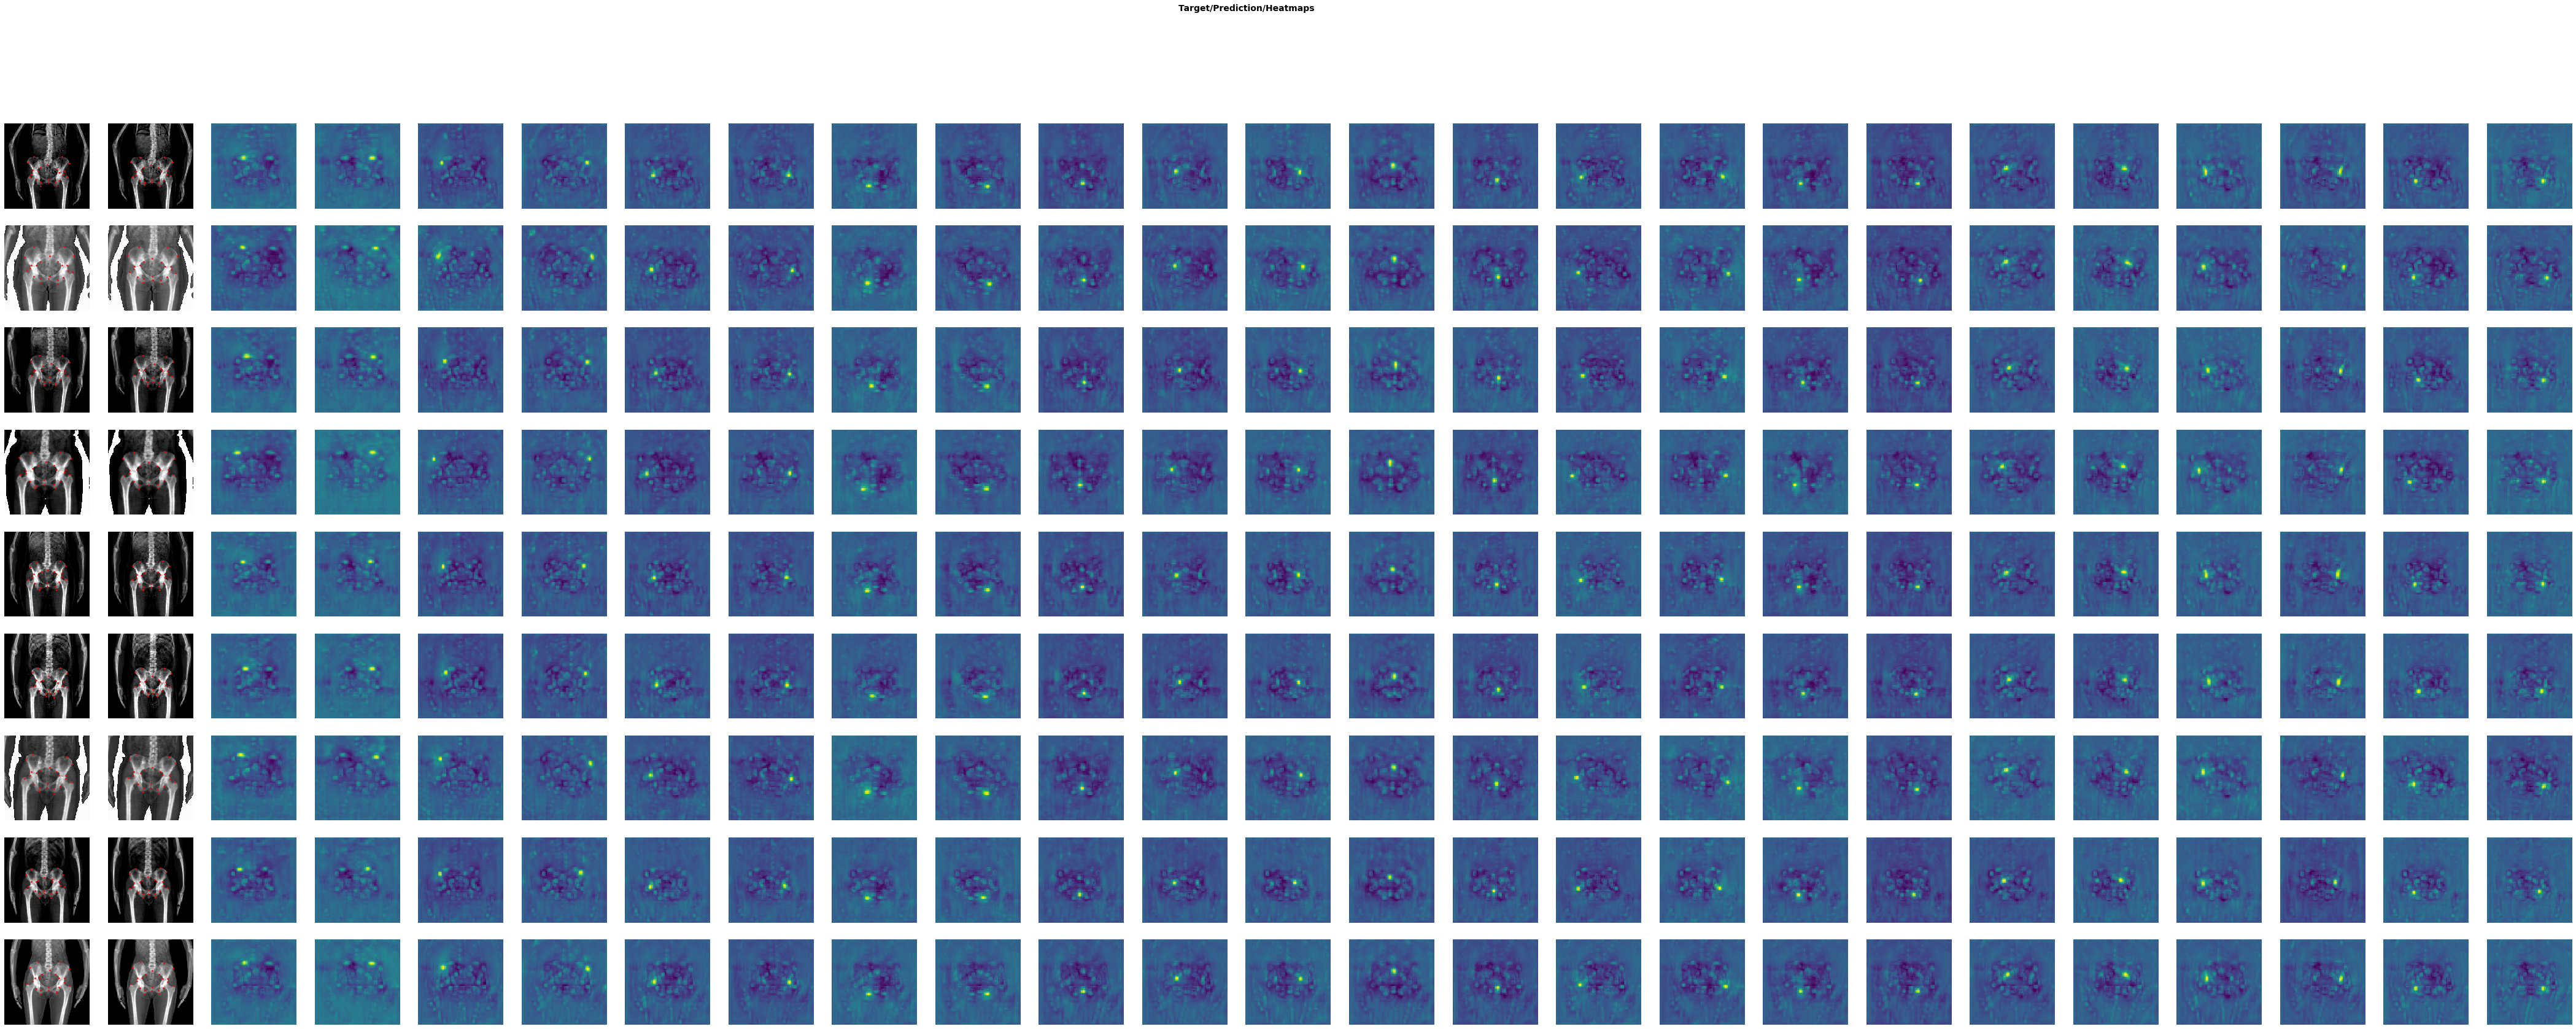

In [27]:
learn.show_results()

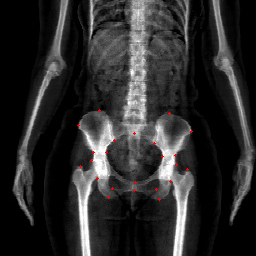

In [28]:
# we test on 

image = Image.open("/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/all_images_cp/08582_82.jpg")
image = image.convert("RGB")

# Create a drawing context
draw = ImageDraw.Draw(image)

# Define the points to annotate
res = learn.predict("/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/all_images_cp/08582_82.jpg")
points = res[0].tolist()

# Draw a circle around each point
for point in points:
    draw.ellipse((point[0]-1, point[1]-1, point[0]+1, point[1]+1), fill="red", outline="red")

image

In [29]:
learn.save("/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/models/hrnet32_hip_23kps_initial")

Path('/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/models/hrnet32_hip_23kps_initial.pth')

### Make prediction on val

In [28]:
learn.load("hrnet32_v2")

In [32]:
int(str(dls.valid.items[0]).split('/')[1].split('.')[0])

'11768'

In [ ]:
val_res = {}

for img in dls.valid.items:
    res = learn.predict(img)[0].tolist()
    val_res[int(str(img).split('/')[1].split('.')[0])] = res

In [34]:
val_res

{11768: [[79.58119201660156, 61.26929473876953],
  [169.2527618408203, 59.217552185058594],
  [42.680381774902344, 86.2669906616211],
  [205.21365356445312, 82.40685272216797],
  [64.59235382080078, 125.01719665527344],
  [186.2257537841797, 125.59632110595703],
  [102.37639617919922, 166.3767547607422],
  [152.88519287109375, 164.52261352539062],
  [126.00777435302734, 157.35153198242188],
  [85.5892562866211, 114.22392272949219],
  [164.68495178222656, 115.3153305053711],
  [125.56104278564453, 91.69047546386719],
  [125.97434997558594, 147.2742919921875],
  [49.12519836425781, 130.36846923828125],
  [202.2738800048828, 132.80007934570312],
  [103.06619262695312, 155.7588653564453],
  [150.5272216796875, 154.9539794921875]],
 17469: [[95.72146606445312, 86.81458282470703],
  [169.76950073242188, 90.66661071777344],
  [73.0990219116211, 95.75875854492188],
  [192.2277374267578, 102.7867660522461],
  [86.401123046875, 130.94912719726562],
  [176.4781951904297, 137.84217834472656],
  [1

In [35]:
with open("val_res_hrnet32.json", "w") as f:
    json.dump(val_res, f)

In [102]:
res = learn.predict("test_image_cp.jpg")

In [103]:
res[0].tolist()

[[99.62843322753906, 72.19834899902344],
 [165.89012145996094, 73.76002502441406],
 [80.0589370727539, 90.80397033691406],
 [188.31698608398438, 92.15665435791016],
 [93.82553100585938, 127.06930541992188],
 [174.8168182373047, 127.78997802734375],
 [113.55075073242188, 162.72189331054688],
 [152.89727783203125, 163.56478881835938],
 [135.28440856933594, 156.6880645751953],
 [107.09151458740234, 114.85791778564453],
 [160.1597442626953, 117.60877990722656],
 [132.55076599121094, 95.55252838134766],
 [135.4573974609375, 148.14735412597656],
 [84.42548370361328, 132.810302734375],
 [186.85939025878906, 136.3827667236328],
 [115.59832000732422, 154.759033203125],
 [152.03684997558594, 155.30938720703125]]

In [19]:
from PIL import Image, ImageDraw

image = Image.open("test_image_cp.jpg")
image = image.convert("RGB")
# Create a drawing context
draw = ImageDraw.Draw(image)

# Define the points to annotate
res = learn.predict("test_image_cp.jpg")
points = res[0].tolist()

# Draw a circle around each point
for point in points:
    draw.ellipse((point[0]-1, point[1]-1, point[0]+1, point[1]+1), fill="red", outline="red")


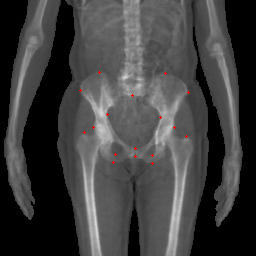

In [20]:
image

### Central crop all images

In [8]:
orgin_path = "/work2/09059/xliaoyi/frontera/narasimhan_lab/xray_orgin_jpg/"
save_path = "/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/all_images_cp"

In [12]:
# for 816x288
path = "816_288_id"
new_size = (256, 256)

for filename in os.listdir(os.path.join(orgin_path, path)):
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join(orgin_path, path, filename))
        width, height = img.size
        left = (width - new_size[0])/2
        top = (height - new_size[1])/2 - 50
        right = (width + new_size[0])/2
        bottom = (height + new_size[1])/2 - 50
        img = img.crop((left, top, right, bottom))
        img.save(os.path.join(save_path, filename), quality=100)

In [13]:
# for 960x384
path = "960_384_id"
new_size = (256, 256)

for filename in os.listdir(os.path.join(orgin_path, path)):
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join(orgin_path, path, filename))
        width, height = img.size
        left = (width - new_size[0])/2
        top = (height - new_size[1])/2 - 50
        right = (width + new_size[0])/2
        bottom = (height + new_size[1])/2 - 50
        img = img.crop((left, top, right, bottom))
        img.save(os.path.join(save_path, filename), quality=100)

### make prediction on all images

In [30]:
learn.load("/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/models/hrnet32_hip_23kps_initial")

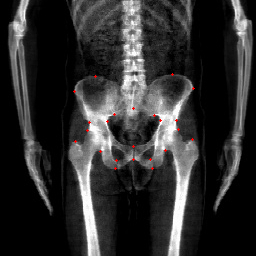

In [31]:
# we test on 

image = Image.open("/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/all_images_cp/15666_82.jpg")
image = image.convert("RGB")

# Create a drawing context
draw = ImageDraw.Draw(image)

# Define the points to annotate
res = learn.predict("/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/all_images_cp/15666_82.jpg")
points = res[0].tolist()

# Draw a circle around each point
for point in points:
    draw.ellipse((point[0]-1, point[1]-1, point[0]+1, point[1]+1), fill="red", outline="red")

image

In [ ]:
root_path = "/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/all_images_cp"
res_dict = {}

for img in os.listdir(root_path):
    img_path = os.path.join(root_path, img)
    res = learn.predict(img_path)[0].tolist()
    res_dict[img.split(".")[0]] = res

In [103]:
save_path = "/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/pred_res"

with open(os.path.join(save_path, "all_res_pred_on_anno_23.json"), "w") as f:
    json.dump(res_dict, f)

In [104]:
len(json.load(open(os.path.join(save_path, "all_res_pred_on_anno.json"))).keys())

39469

In [8]:
save_path = "/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/pred_res/"
res_dict = json.load(open(save_path + "all_res_pred_on_anno_23.json"))

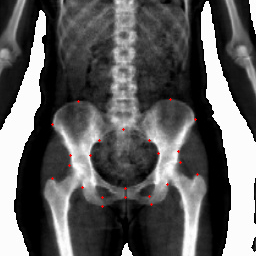

In [11]:
# we test on 

image = Image.open("/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/all_images_cp/00001_93.jpg")
image = image.convert("RGB")

# Create a drawing context
draw = ImageDraw.Draw(image)

# Define the points to annotate
# res = learn.predict("/work2/09059/xliaoyi/frontera/narasimhan_lab/hip_shape/images/all_images_cp/18888_82.jpg")
# points = res[0].toist()
points = res_dict['00001_93']

# Draw a circle around each point
for point in points:
    draw.ellipse((point[0]-1, point[1]-1, point[0]+1, point[1]+1), fill="red", outline="red")

image

In [ ]:
res_dict